In [88]:
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
import multiprocessing as mp

import vplanet_inference as vpi

In [89]:
import vplanet 
import alabi
from matplotlib import rcParams
rcParams['font.family'] = 'stixgeneral'
rcParams['text.usetex'] = False
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16


### XUV luminosity model from [Ribas et al. 2005](https://iopscience.iop.org/article/10.1086/427977) (R05)

\begin{align}
\frac{L_\mathrm{XUV}}{L_\mathrm{bol}} = \left\{
				\begin{array}{lcr}
					f_\mathrm{sat} &\ & t \leq t_\mathrm{sat} \\
					f_\mathrm{sat}\left(\frac{t}{t_\mathrm{sat}}\right)^{-\beta_\mathrm{XUV}} &\ & t > t_\mathrm{sat}
				\end{array}
				\right.,
\end{align}

where 

$L_\mathrm{XUV} / L_\mathrm{bol}$ is the ratio of X-ray luminosity to bolometric (total) luminosity

$f_{sat}$ is the constant ratio of stellar XUV to bolometric luminosity during the saturated phase

$t_{sat}$ is the duration of the saturated phase

$\beta_{XUV}$ is the exponent that controls how steeply $L_{\rm XUV}$ decays after saturation

### XUV luminosity model from [Johnstone et al. 2021](https://arxiv.org/abs/2009.07695) (J21)

\begin{equation} 
    \frac{L_\mathrm{X}}{L_\mathrm{bol}} = \left \{
    \begin{array}{ll}
    C_1 Ro^{\beta_1}, & \text{if }  Ro \ge Ro_\mathrm{sat},\\
    C_2 Ro^{\beta_2}, & \text{if }  Ro \le Ro_\mathrm{sat},\\
    \end{array} \right.
\end{equation}

where 

$L_\mathrm{X} / L_\mathrm{bol}$ is the ratio of X-ray luminosity to bolometric (total) luminosity

$R_o$ is the Rossby number (the rotation period / convective turnover timescale of the star)

$C_1$, $C_2$, $\beta_1$, and $\beta_2$ are constants

### Best fit values from the paper:

$\beta_1 = -0.135 \pm 0.030$

$\beta_2 = -1.889 \pm 0.079$

$Ro_\mathrm{sat} = 0.0605 \pm 0.00331$

$R_\mathrm{X,sat} = 5.135 \times 10^{-4} \pm 3.320 \times 10^{-5}$

$R_\mathrm{X,sat}$ is the value of $R_\mathrm{X}$ at $Ro_\mathrm{sat}$
and the constants $C_1$, $C_2$ can be solved for using the relation:
$R_\mathrm{X,sat} = C_1 Ro_\mathrm{sat}^{\alpha_1} = C_2 Ro_\mathrm{sat}^{\alpha_2}$

Why we will use the Johnstone 2021 model:
- model parameters are not dependent on stellar mass
- constants have been empirically calibrated from a large sample of FGKM dwarfs (see Figure 4 of the paper)

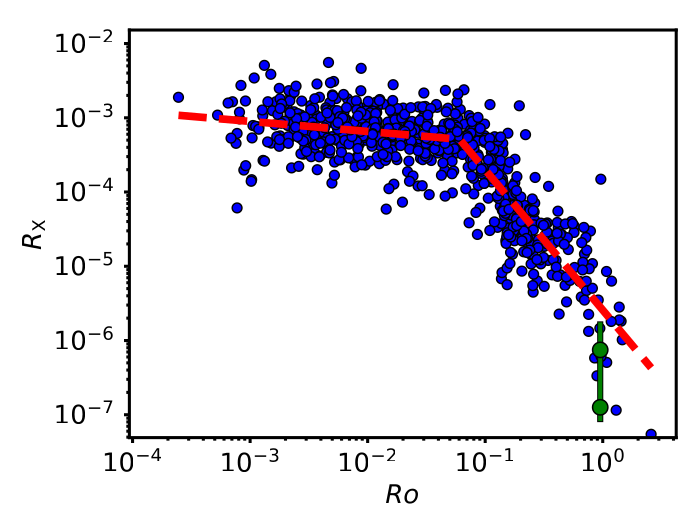


In [90]:
# To run implement the Johnstone model, we will define the mean and uncertainty for the model parameters

j21 = {"beta1": (-0.135, 0.030),
       "beta2": (-1.889, 0.079),
       "Rosat": (0.0605, 0.00331),
       "RXsat": (5.135e-4, 3.320e-5)}

In [4]:
# Initialize the vplanet model with the input and output parameters

inpath = "../infiles/stellar/"
outpath = "output/"

inparams = {"star.dMass": u.Msun,
            "star.dRotPeriod": u.days,
            "vpl.dStopTime": u.Gyr}

outparams = {"final.star.Luminosity": u.Lsun,
             "final.star.RotPer": u.days,
             "final.star.RossbyNumber": u.dimensionless_unscaled}

vpm = vpi.VplanetModel(inparams=inparams,
                       outparams=outparams,
                       inpath=inpath,
                       outpath=outpath,
                       time_init=5e6*u.yr,
                       timesteps=1e6*u.yr,
                       verbose=True)

In [5]:
# Implement the additional equations needed for the Johnstone XUV luminosity model

def LXUV_model(mstar, prot, age, beta1, beta2, Rosat, RXsat):

    evol = vpm.run_model(np.array([mstar, prot, age]), remove=True)
    ross = evol["final.star.RossbyNumber"]
    lbol = evol["final.star.Luminosity"]

    C1 = RXsat / Rosat**beta1
    C2 = RXsat / Rosat**beta2
    
    rx = np.zeros(len(ross))
    for ii in range(len(ross)):
        if ross[ii] < Rosat:
            rx[ii] = C1 * ross[ii]**beta1
        else:
            rx[ii] = C2 * ross[ii]**beta2

    evol["final.star.RX"] = rx
    evol["final.star.LXUV"] = rx * lbol

    return evol

Test the Johnstone model for a single star with $M_* = 1\, M_{\odot}$, initial $P_{\rm rot} = 0.5$ days, $t_{\rm age} = 9$ Gyr, and constants ($\beta_1$, $\beta_2$, $Ro_\mathrm{sat}$, $R_\mathrm{X,sat}$) from the J21 paper:

In [24]:
# inputs: theta = [mstar, prot, age, beta1, beta2, Rosat, RXsat]

theta = np.array([1.0, 0.5, 9.0, j21["beta1"][0], j21["beta2"][0], j21["Rosat"][0], j21["RXsat"][0]])
evol = LXUV_model(*theta)


Input:
-----------------
star.dMass : 1.0 [solMass] (user)   --->   1.988409870698051e+30 [kg] (vpl file)
star.dRotPeriod : 0.5 [days] (user)   --->   43200.0 [s] (vpl file)
vpl.dStopTime : 9.0 [Gyr] (user)   --->   2.840184e+17 [s] (vpl file)

Created file output//263062553997760/vpl.in
Created file output//263062553997760/star.in


Executed model output//263062553997760/vpl.in 33.453 s

Output:
-----------------
final.star.Luminosity : 1.46994644723093 [solLum]
final.star.RossbyNumber : 3.667143 []
final.star.RotPer : 47.50030092592592 [days]



In [6]:
def plot_evolution(evols, title="Johnstone 2021"):

    fig, axs = plt.subplots(3, 1, figsize=[10,14], sharex=True)

    for evol in evols:
        lbol = evol["final.star.Luminosity"].to(u.erg/u.s)
        #lbol = evol["final.star.Luminosity"].to(u.erg/u.s)
        lxuv = evol["final.star.LXUV"].to(u.erg/u.s)
        #lxuv = evol["final.star.LXUV"].to(u.erg/u.s)
        prot = evol["final.star.RotPer"]

        axs[0].plot(evol["Time"], lbol, color="k", alpha=0.5)
        axs[1].plot(evol["Time"], lxuv, color="k", alpha=0.5)
        axs[2].plot(evol["Time"], prot, color="k", alpha=0.5)

    axs[0].set_title(title, fontsize=24)
    axs[0].set_ylabel("Bolometric Luminosity [{}]".format(lbol.unit), fontsize=20)
    #axs[0].set_ylabel("Bolometric Luminosity [{}]".format(lbol.unit), fontsize=20)
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')

    axs[1].set_ylabel("X-ray Luminosity [{}]".format(lxuv.unit), fontsize=20)
    #axs[1].set_ylabel("X-ray Luminosity [{}]".format(lxuv.unit), fontsize=20)
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')

    axs[2].set_ylabel("Rotation Period [{}]".format(prot.unit), fontsize=20)
    #axs[2].set_ylabel("Rotation Period [{}]".format(prot.unit), fontsize=20)
    axs[2].set_xlabel("Time [yr]", fontsize=20)
    axs[2].set_xscale('log')
    axs[2].set_yscale('log')

    axs[0].set_xlim(min(evol["Time"].value), max(evol["Time"].value))
    plt.tight_layout()
    
    return fig

/tmp/ipykernel_1669/1076678197.py:33: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[0].set_xlim(min(evol["Time"].value), max(evol["Time"].value))


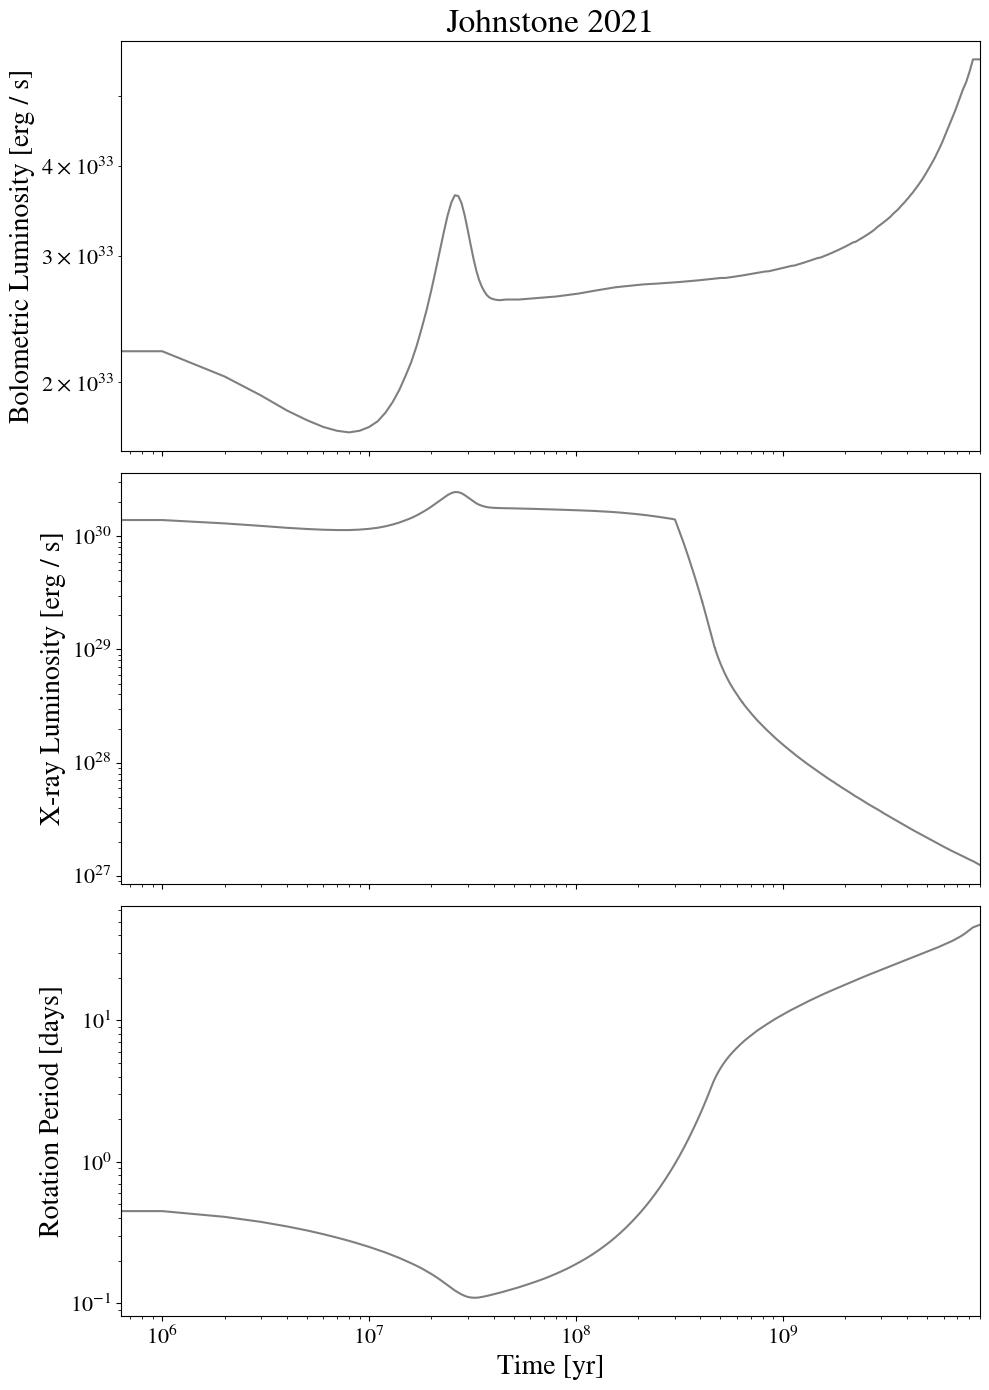

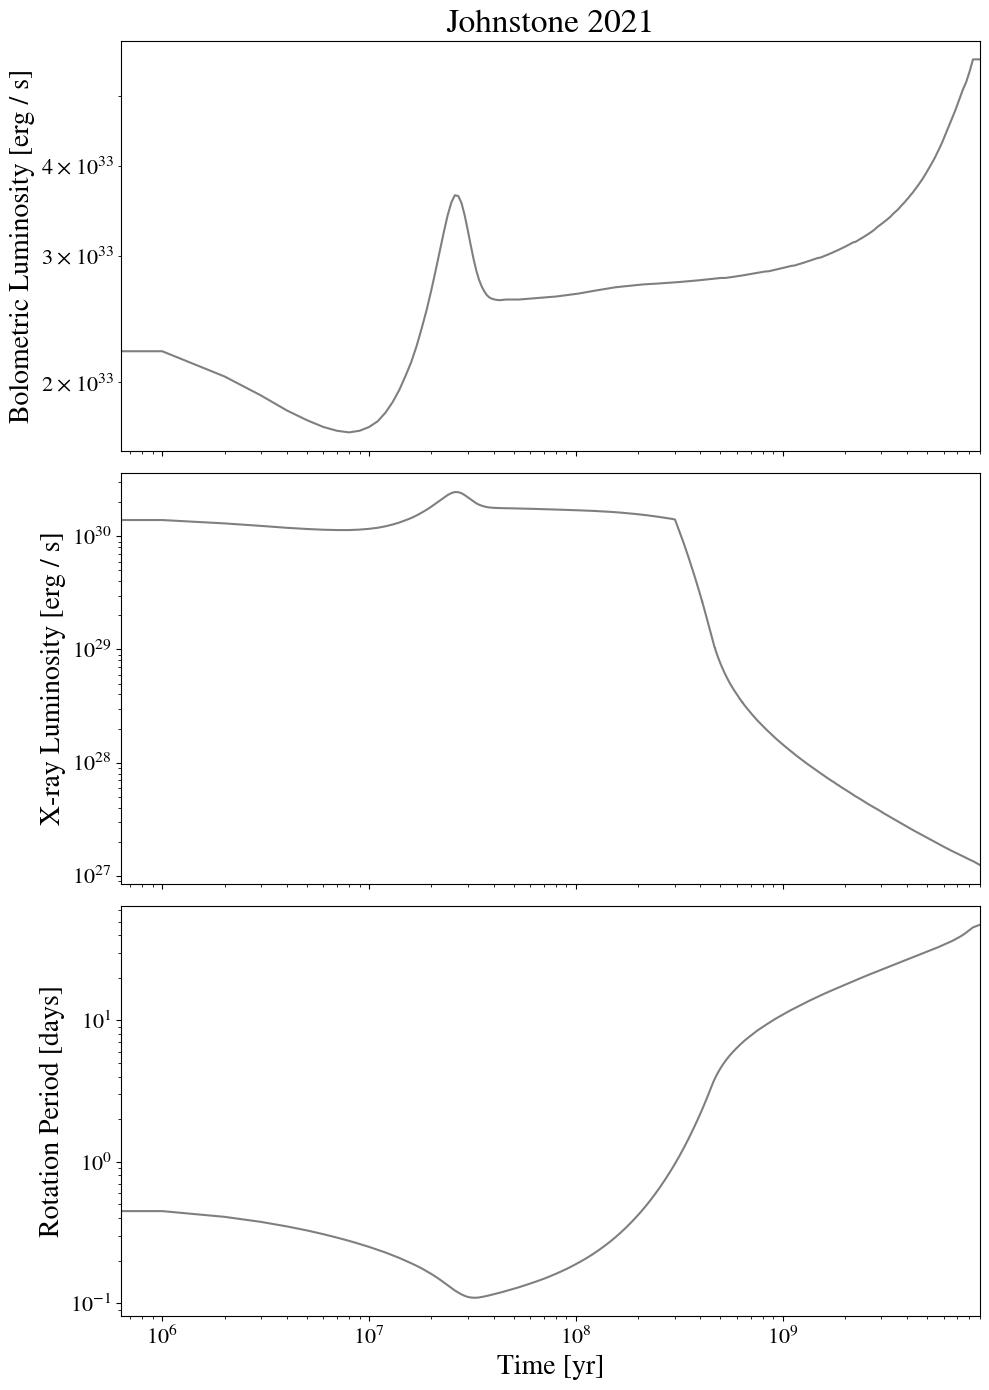

In [42]:
plot_evolution([evol])

# note that the input to the plot_evolution function is a list of dictionaries, where each dictionary is the output of the LXUV_model function
# since evol is a single dictionary, we add brackets around it to make it a list

### Parameter sweep

Let's try sampling a range of different plausible models for Trappist-1, given the known parameters and uncertainties

In [44]:
# Trappist-1

nsamp = 20
mass_samp = np.random.normal(0.089, 0.007, nsamp)
prot_samp = np.random.uniform(0.01, 5.0, nsamp)
age_samp = np.ones(nsamp) * 9.0
beta1_samp = np.random.normal(j21["beta1"][0], j21["beta1"][1], nsamp)
beta2_samp = np.random.normal(j21["beta2"][0], j21["beta2"][1], nsamp)
Rosat_samp = np.random.normal(j21["Rosat"][0], j21["Rosat"][1], nsamp)
RXsat_samp = np.random.normal(j21["RXsat"][0], j21["RXsat"][1], nsamp)

thetas = np.array([mass_samp, prot_samp, age_samp, beta1_samp, beta2_samp, Rosat_samp, RXsat_samp]).T

# Run with multiple cores
ncores = mp.cpu_count()
print("number of cores available:", ncores)
with mp.Pool(ncores) as pool:
    evols = pool.starmap(LXUV_model, thetas)

# If multiple cores does not work, comment out the previous two lines and uncomment the following lines 
# evols = []
# for ii in range(nsamp):
#     evols.append(LXUV_model(*thetas[ii]))

number of cores available: 8

Input:
Input:
Input:
Input:
Input:
Input:



-----------------
Input:

---------------------------------------------------
-----------------


----------------------------------
star.dMass : 0.07396838141007951 [solMass] (user)   --->   1.4707945971536031e+29 [kg] (vpl file)
star.dMass : 0.08296361683033386 [solMass] (user)   --->   1.649656746142468e+29 [kg] (vpl file)star.dMass : 0.07894486040442886 [solMass] (user)   --->   1.5697473966904606e+29 [kg] (vpl file)
star.dMass : 0.09717316657188084 [solMass] (user)   --->   1.9322008357851376e+29 [kg] (vpl file)star.dMass : 0.08117145056809139 [solMass] (user)   --->   1.6140211352847183e+29 [kg] (vpl file)
star.dMass : 0.08079068208353614 [solMass] (user)   --->   1.6064498971533143e+29 [kg] (vpl file)



star.dRotPeriod : 3.9429802681281436 [days] (user)   --->   340673.49516627163 [s] (vpl file)
star.dRotPeriod : 1.6484700124610887 [days] (user)   --->   142427.80907663808 [s] (vpl file)star.dRotPeriod :

Next, let's plot the models we just ran and see how the evolution models (black lines) compare to the observational data (red lines) of the system at present day 
using data from [https://jbirky.github.io/yupra/docs/datasets.html](https://jbirky.github.io/yupra/docs/datasets.html)

Note: make sure that the units are consistent with those in the data table.

Then plot the observational constraints and uncertainties on top of the models, to compare how well the models match the data.

In [45]:
# data = [mean, lower error, upper error]

Lbol_data = np.array([5.22e-4, -0.19e-4, 0.19e-4]) * u.Lsun
Lbol_data = Lbol_data.to(u.erg/u.s).value

Lxuv_data = np.array([1.0e-4, -0.1e-4, 0.1e-4]) * Lbol_data * u.Lsun
Lxuv_data = Lxuv_data.value

Prot_data = np.array([3.295, -0.003, 0.003]) * u.day
Prot_data = Prot_data.value

age_data = np.array([7.6, -2.2, 2.2]) * u.Gyr
age_data = age_data.to(u.yr).value

/tmp/ipykernel_609661/1558624661.py:28: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[0].set_xlim(min(evol["Time"].value), max(evol["Time"].value))
/tmp/ipykernel_609661/1055320492.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


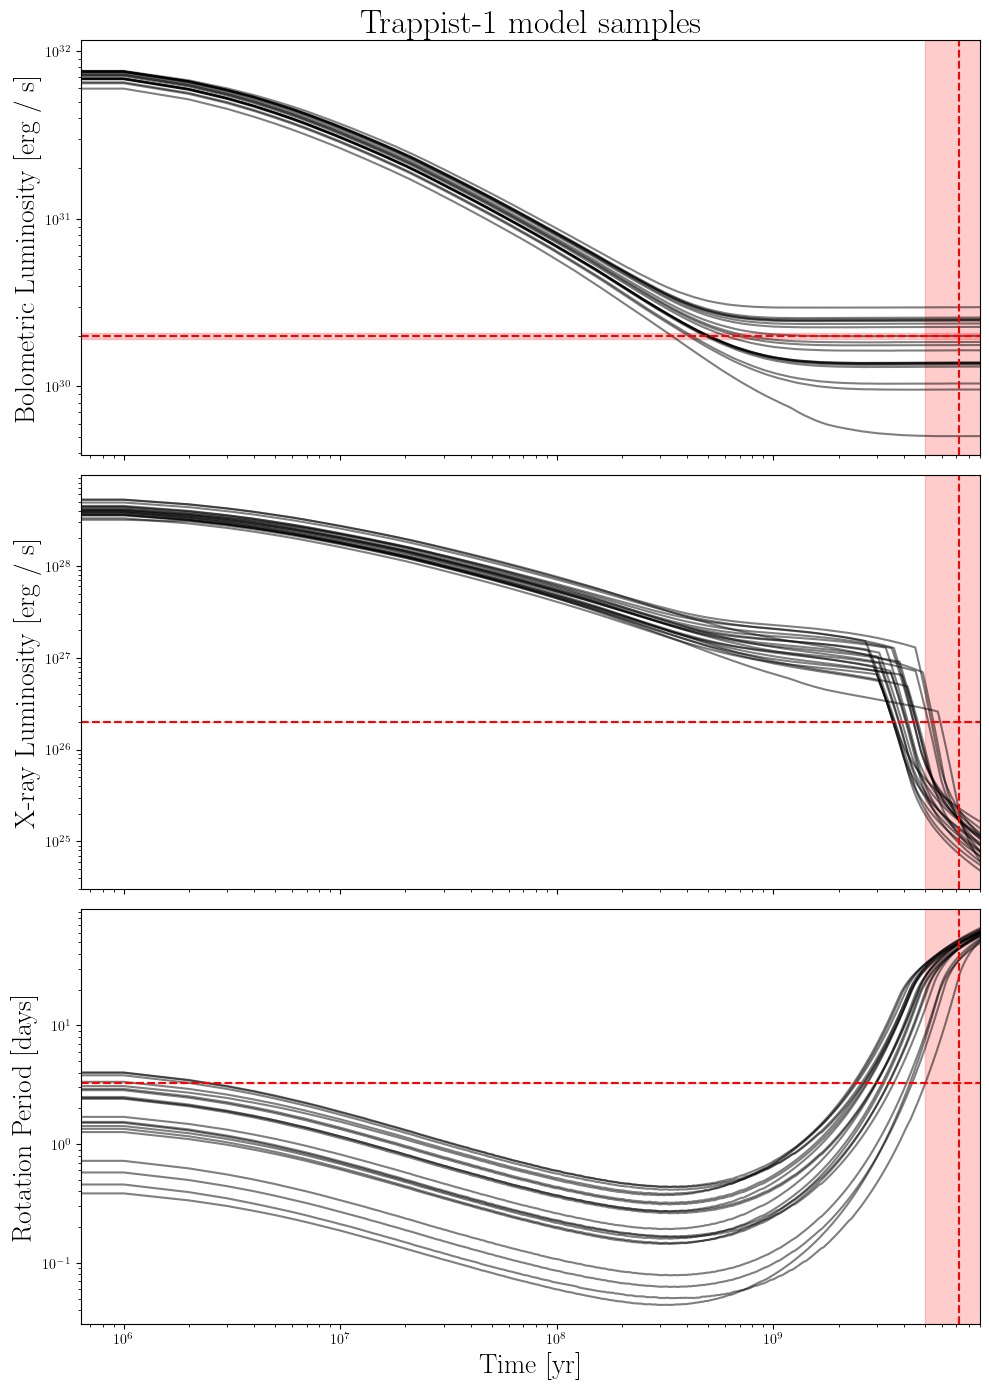

In [73]:
fig = plot_evolution(evols, title="Trappist-1 model samples")
axs = fig.axes

axs[0].axhline(Lbol_data[0], color="r", linestyle="--")
axs[0].axhspan(Lbol_data[0]+Lbol_data[1], Lbol_data[0]+Lbol_data[2], color="r", alpha=0.2)

axs[1].axhline(Lxuv_data[0], color="r", linestyle="--")
axs[1].axhspan(Lxuv_data[0]+Lxuv_data[1], Lxuv_data[0]+Lxuv_data[2], color="r", alpha=0.2)

axs[2].axhline(Prot_data[0], color="r", linestyle="--")
axs[2].axhspan(Prot_data[0]+Prot_data[1], Prot_data[0]+Prot_data[2], color="r", alpha=0.2)

for ii in range(len(axs)):
    axs[ii].axvline(age_data[0], color="r", linestyle="--")
    axs[ii].axvspan(age_data[0]+age_data[1], age_data[0]+age_data[2], color="r", alpha=0.2)

fig.show()

Note: for the Trappist system, the constraints on rotation period and xray luminosity suggest a younger age (~1-3 Gyr, based on where the models intersect the horizontal red lines) than what is reported in literature ($7.6\pm2.2$ Gyr, from Burgasser and Mamajek 2017). However, age is one of the most difficult parameters to reliably measure for a star, so it is not too surprising that the literature age is inconsistent.

### GJ 1132 model 

In [95]:
j21 = {"beta1": (-0.135, 0.030),
       "beta2": (-1.889, 0.079),
       "Rosat": (0.0605, 0.00331),
       "RXsat": (5.135e-4, 3.320e-5)}
#constants

In [96]:
# Initialize the vplanet model with the input and output parameters

inpath = "../infiles/stellar/"
outpath = "output/"

inparams = {"star.dMass": u.Msun,
            "star.dRotPeriod": u.days,
            "vpl.dStopTime": u.Gyr}

outparams = {"final.star.Luminosity": u.Lsun,
             "final.star.RotPer": u.days,
             "final.star.RossbyNumber": u.dimensionless_unscaled,
             "final.star.Radius": u.Rsun}

vpm = vpi.VplanetModel(inparams=inparams,
                       outparams=outparams,
                       inpath=inpath,
                       outpath=outpath,
                       time_init=5e6*u.yr,
                       timesteps=1e6*u.yr,
                       verbose=True)

In [103]:
def flux_to_luminosity(Flux,Radius):
    Luminosity = Flux*4*np.pi*Radius**2
    return Luminosity
def luminosity_to_flux(Luminosity, Radius):
    Flux = Luminosity/(Radius**2*4*np.pi)
    return Flux
##def EUV_relation(LuminosityXray, Radius):
    FluxXray = LuminosityToFlux(LuminosityXray, Radius)
    LogFluxEUV1= 2.04 + 0.681 * np.log10(FluxXray)
    FluxEUV1=10**LogFluxEUV1
    LogFluxEUV2 = -0.341 + 0.920*LogFluxEUV1
    FluxEUV2 = 10**LogFluxEUV2
    FluxEUV = FluxEUV1 + FluxEUV2
    LuminosityEUV = FluxToLuminosity(FluxEUV,Radius)
    return LuminosityEUV

def EUV_relation(Lxray, Radius):

    Fxray = luminosity_to_flux(Lxray.cgs.value, Radius.cgs.value)
    log_FEUV1 = 2.04 + 0.681 * np.log10(Fxray)
    FEUV1 = 10**log_FEUV1
    log_FEUV2 = -0.341 + 0.920 * log_FEUV1
    FEUV2 = 10**log_FEUV2
    FEUV = (FEUV1 + FEUV2) * u.erg / u.s / u.cm**2

    return flux_to_luminosity(FEUV, Radius)

# Implement the additional equations needed for the Johnstone XUV luminosity model

def LXUV_model(mstar, prot, age, beta1, beta2, Rosat, RXsat):

    evol = vpm.run_model(np.array([mstar, prot, age]), remove=True)
    ross = evol["final.star.RossbyNumber"]
    lbol = evol["final.star.Luminosity"]
    Radius = evol["final.star.Radius"]

    C1 = RXsat / Rosat**beta1
    C2 = RXsat / Rosat**beta2
    
    rx = np.zeros(len(ross))
    for ii in range(len(ross)):
        if ross[ii] < Rosat:
            rx[ii] = C1 * ross[ii]**beta1
        else:
            rx[ii] = C2 * ross[ii]**beta2

    evol["final.star.RX"] = rx
    evol["final.star.LXray"] = rx * lbol
    evol["final.star.LEUV"] = EUV_relation(evol["final.star.LXray"],Radius)
    evol["final.star.LXUV"] = evol["final.star.LXray"]+evol["final.star.LEUV"]

    return evol

In [104]:
# inputs: theta = [mass star, p rotations, age, beta1, beta2, Rosat, RXsat]     
#changed Theta to omega to differentiate 

Omega = np.array([0.181, 122.31, 5.0, j21["beta1"][0], j21["beta2"][0], j21["Rosat"][0], j21["RXsat"][0]])
evol = LXUV_model(*Omega)


Input:
-----------------
star.dMass : 0.181 [solMass] (user)   --->   3.599021865963472e+29 [kg] (vpl file)
star.dRotPeriod : 122.31 [days] (user)   --->   10567584.0 [s] (vpl file)
vpl.dStopTime : 5.0 [Gyr] (user)   --->   1.57788e+17 [s] (vpl file)

Created file output//181037736625512/vpl.in
Created file output//181037736625512/star.in
Executed model output//181037736625512/vpl.in 12.582 s

Output:
-----------------
final.star.Luminosity : 0.0038242267502612325 [solLum]
final.star.Radius : 0.19854779358919072 [solRad]
final.star.RossbyNumber : 0.840916 []
final.star.RotPer : 50.96005787037037 [days]



In [105]:
def plot_evolution(evols, title="GJ 1132 model samples"):

    fig, axs = plt.subplots(3, 1, figsize=[10,14], sharex=True)

    for evol in evols:
        lbol = evol["final.star.Luminosity"].to(u.erg/u.s)
        #lbol = evol["final.star.Luminosity"].to(u.erg/u.s)
        lxuv = evol["final.star.LXUV"].to(u.erg/u.s)
        #lxuv = evol["final.star.LXUV"].to(u.erg/u.s)
        prot = evol["final.star.RotPer"]

        axs[0].plot(evol["Time"], lbol, color="k", alpha=0.5)
        axs[1].plot(evol["Time"], lxuv, color="k", alpha=0.5)
        axs[2].plot(evol["Time"], prot, color="k", alpha=0.5)

    axs[0].set_title(title, fontsize=24)
    axs[0].set_ylabel("Bolometric Luminosity [{}]".format(lbol.unit), fontsize=20)
    #axs[0].set_ylabel("Bolometric Luminosity [{}]".format(lbol.unit), fontsize=20)
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')

    axs[1].set_ylabel("X-ray Luminosity [{}]".format(lxuv.unit), fontsize=20)
    #axs[1].set_ylabel("X-ray Luminosity [{}]".format(lxuv.unit), fontsize=20)
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')

    axs[2].set_ylabel("Rotation Period [{}]".format(prot.unit), fontsize=20)
    #axs[2].set_ylabel("Rotation Period [{}]".format(prot.unit), fontsize=20)
    axs[2].set_xlabel("Time [yr]", fontsize=20)
    axs[2].set_xscale('log')
    axs[2].set_yscale('log')

    axs[0].set_xlim(min(evol["Time"].value), max(evol["Time"].value))
    plt.tight_layout()
    
    return fig

/tmp/ipykernel_17746/687210072.py:33: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[0].set_xlim(min(evol["Time"].value), max(evol["Time"].value))


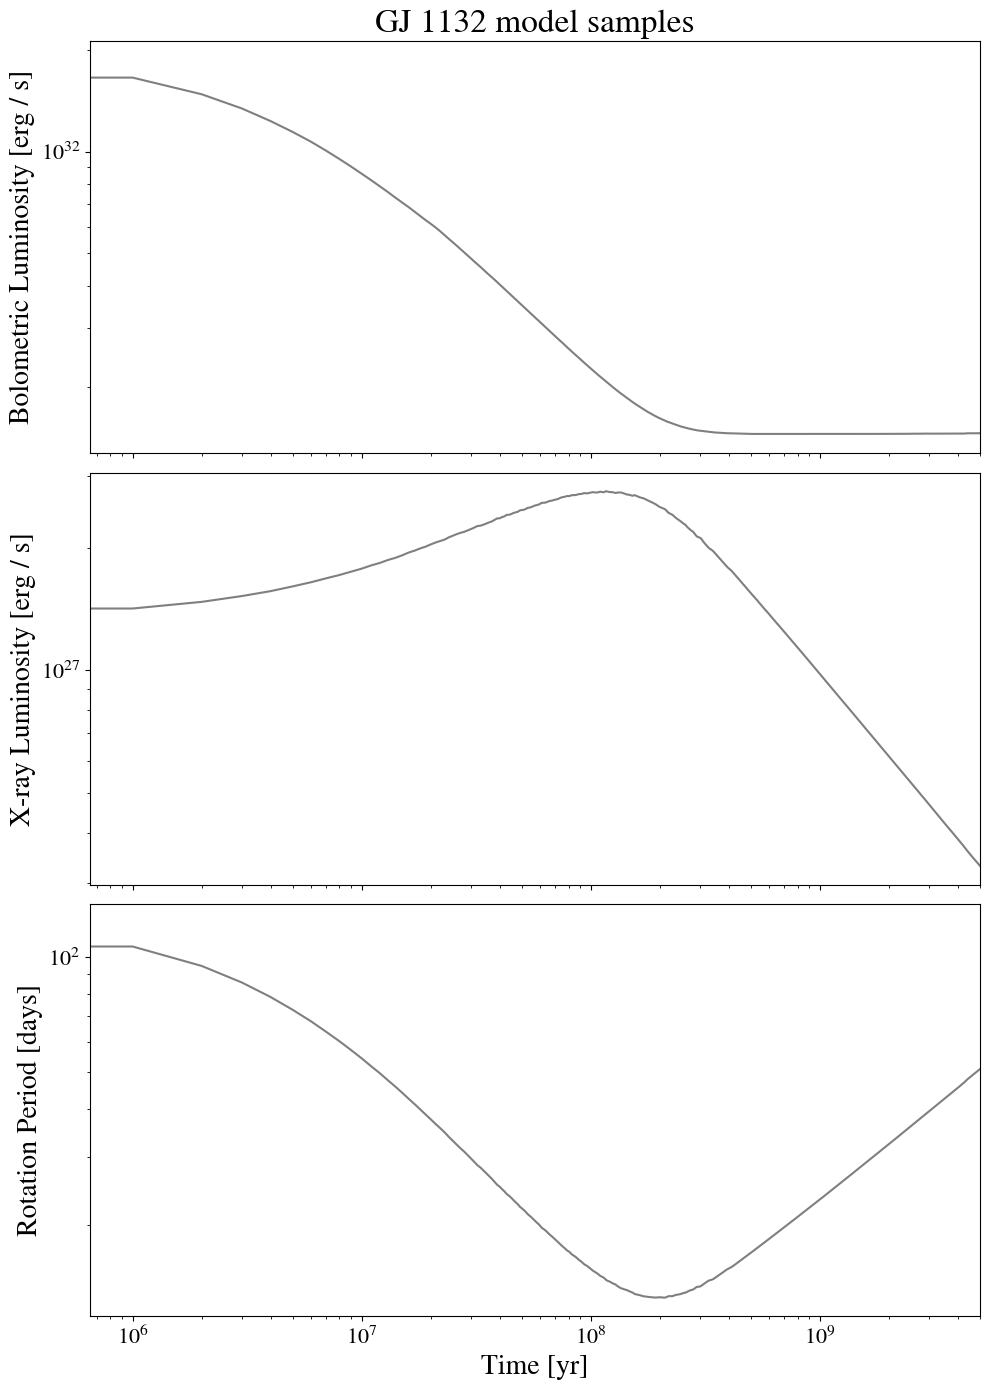

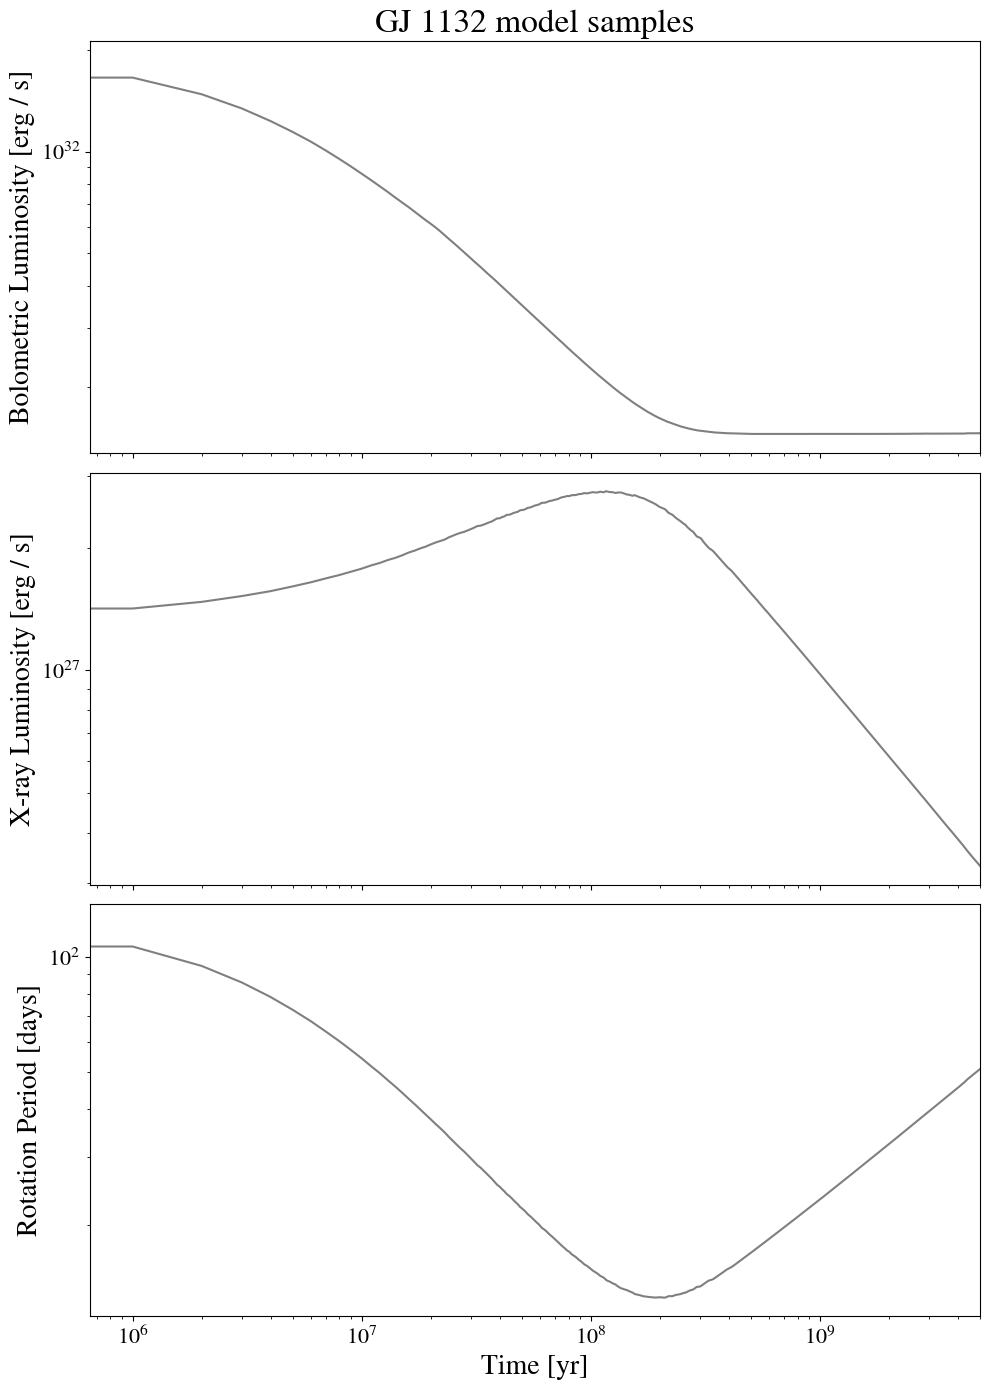

In [106]:
plot_evolution([evol])


### Sample 1

Parameters and uncertainties of GJ 1132 model

    From Host star parameters from Exostars catalog and NASA exoplanet archive


In [108]:
#Parameters and uncertainties
#Thetas to Omega2
#[best fit, standard deviation, nsamp]
nsamp = 20
mass_samp = np.random.normal(0.181	, 0.019, nsamp)
prot_samp = np.random.uniform(0.01,10, nsamp)
age_samp = np.ones(nsamp) * 9.0
beta1_samp = np.random.normal(j21["beta1"][0], j21["beta1"][1], nsamp)
beta2_samp = np.random.normal(j21["beta2"][0], j21["beta2"][1], nsamp)
Rosat_samp = np.random.normal(j21["Rosat"][0], j21["Rosat"][1], nsamp)
RXsat_samp = np.random.normal(j21["RXsat"][ 0], j21["RXsat"][1], nsamp)

Omega2 = np.array([mass_samp, prot_samp, age_samp, beta1_samp, beta2_samp, Rosat_samp, RXsat_samp]).T

# Run with multiple cores
ncores = mp.cpu_count()
print("number of cores available:", ncores)
with mp.Pool(ncores) as pool:
    evols = pool.starmap(LXUV_model, Omega2)

# If multiple cores does not work, comment out the previous two lines and uncomment the following lines 
# evols = []
# for ii in range(nsamp):
#     evols.append(LXUV_model(*thetas[ii]))

number of cores available: 8

Input:
Input:
Input:
Input:
Input:

Input:
Input:

-----------------


---------------------------------------------------

-----------------

-----------------
-----------------

star.dMass : 0.15703723008839035 [solMass] (user)   --->   3.1225437837483633e+29 [kg] (vpl file)star.dMass : 0.16525265688777516 [solMass] (user)   --->   3.285900141147304e+29 [kg] (vpl file)
Input:star.dMass : 0.1668681633138864 [solMass] (user)   --->   3.3180230303858614e+29 [kg] (vpl file)star.dMass : 0.18076642211965985 [solMass] (user)   --->   3.594377380335021e+29 [kg] (vpl file)
star.dMass : 0.1564711152091967 [solMass] (user)   --->   3.1112870996109866e+29 [kg] (vpl file)



star.dMass : 0.1699509207537391 [solMass] (user)   --->   3.379320883609571e+29 [kg] (vpl file)star.dRotPeriod : 2.142368317515354 [days] (user)   --->   185100.62263332657 [s] (vpl file)star.dRotPeriod : 5.679316422817621 [days] (user)   --->   490692.93893144245 [s] (vpl file)

----------------

In [109]:
# data = [mean, lower error, upper error]

Lbol_data = np.array([0.00438	,-0.00034,	0.00034]) * u.Lsun
Lbol_data = Lbol_data.to(u.erg/u.s).value

Lxuv_data = (np.array([9.96e25,	-2.95e25,	2.95e25]) * u.erg / u.s )
Lxuv_data = Lxuv_data.value

Prot_data = np.array([122.31, -5.04, 6.03]) * u.day
Prot_data = Prot_data.value

age_data = np.array([5, 5, 5]) * u.Gyr
age_data = age_data.to(u.yr).value

/tmp/ipykernel_17746/687210072.py:33: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[0].set_xlim(min(evol["Time"].value), max(evol["Time"].value))
/tmp/ipykernel_17746/64737029.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


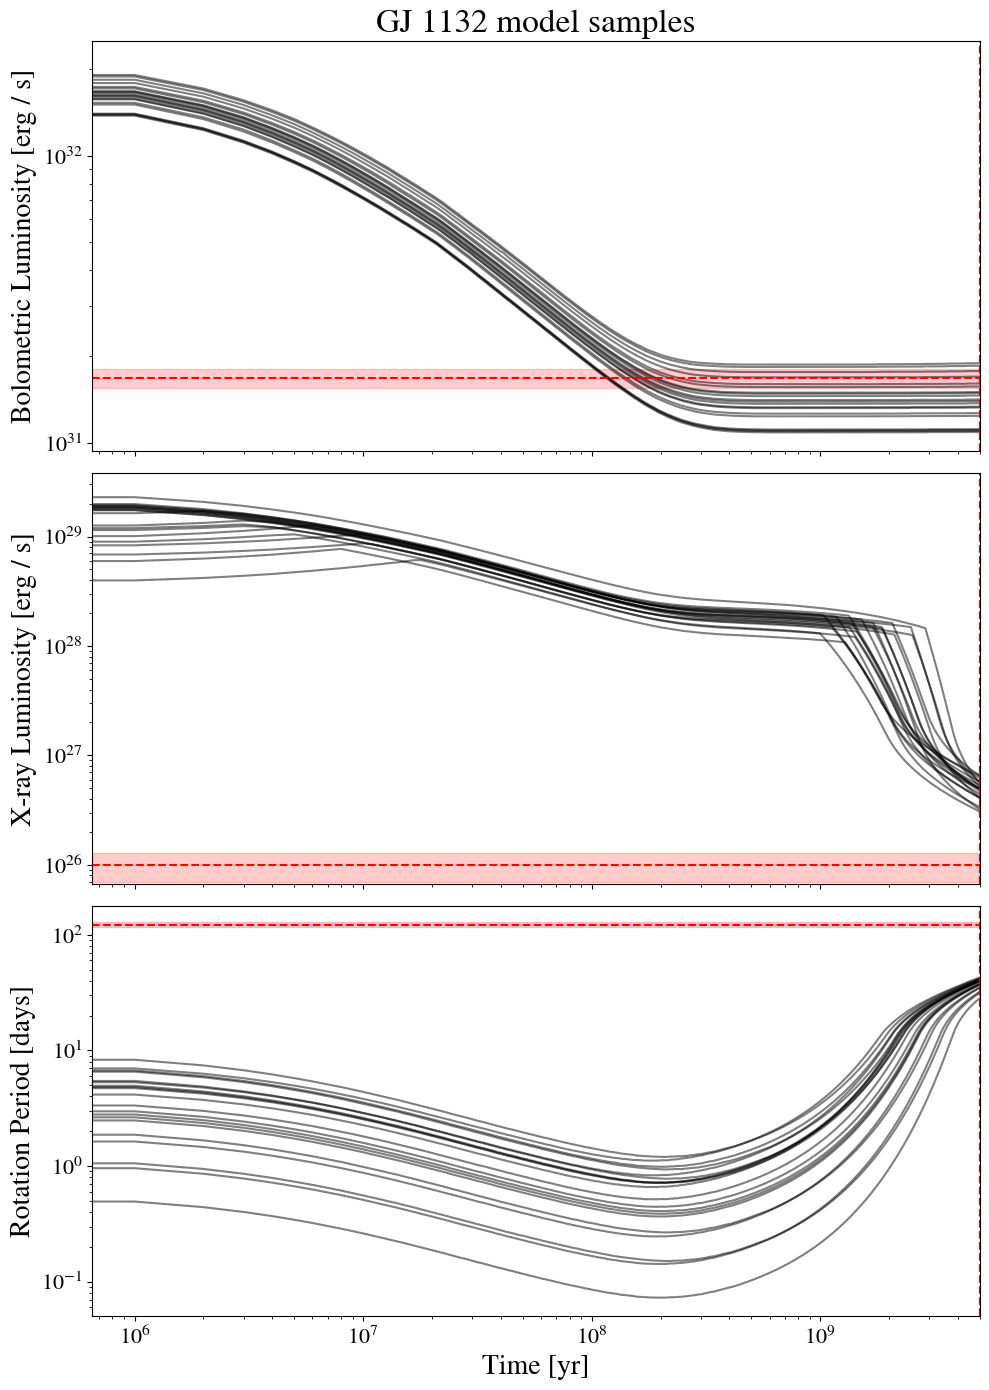

In [110]:
fig = plot_evolution(evols, title="GJ 1132 model samples")
axs = fig.axes

axs[0].axhline(Lbol_data[0], color="r", linestyle="--")
axs[0].axhspan(Lbol_data[0]+Lbol_data[1], Lbol_data[0]+Lbol_data[2], color="r", alpha=0.2)

axs[1].axhline(Lxuv_data[0], color="r", linestyle="--")
axs[1].axhspan(Lxuv_data[0]+Lxuv_data[1], Lxuv_data[0]+Lxuv_data[2], color="r", alpha=0.2)

axs[2].axhline(Prot_data[0], color="r", linestyle="--")
axs[2].axhspan(Prot_data[0]+Prot_data[1], Prot_data[0]+Prot_data[2], color="r", alpha=0.2)

for ii in range(len(axs)):
    axs[ii].axvline(age_data[0], color="r", linestyle="--")
    axs[ii].axvspan(age_data[0]+age_data[1], age_data[0]+age_data[2], color="r", alpha=0.2)

fig.show()

In [111]:
model1_finalXUV =(evols[0]["final.star.LXUV"][-1]).to(u.erg/u.s).value
(model1_finalXUV - Lxuv_data[0])**2/Lxuv_data[1]**2
#closer to 0 is less deviation, getting mean from the data and comparing to original mean, chi squared 

111.91118487989252

### Sample 2 GJ 3470

Parameters and uncertainties of GJ 3470 model

    From Host star parameters from Exostars catalog and NASA exoplanet archive


In [129]:
#Parameters and uncertainties
#Thetas to Omega2
#[best fit, standard deviation, nsamp]
nsamp = 20
mass_samp = np.random.normal(0.51	, 0.06, nsamp)
prot_samp = np.random.uniform(5, 20, nsamp)
age_samp = np.ones(nsamp) * 9
beta1_samp = np.random.normal(j21["beta1"][0], j21["beta1"][1], nsamp)
beta2_samp = np.random.normal(j21["beta2"][0], j21["beta2"][1], nsamp)
Rosat_samp = np.random.normal(j21["Rosat"][0], j21["Rosat"][1], nsamp)
RXsat_samp = np.random.normal(j21["RXsat"][0], j21["RXsat"][1], nsamp)

Omega2 = np.array([mass_samp, prot_samp, age_samp, beta1_samp, beta2_samp, Rosat_samp, RXsat_samp]).T

# Run with multiple cores
ncores = mp.cpu_count()
print("number of cores available:", ncores)
with mp.Pool(ncores) as pool:
    evols = pool.starmap(LXUV_model, Omega2)

# If multiple cores does not work, comment out the previous two lines and uncomment the following lines 
# evols = []
# for ii in range(nsamp):
#     evols.append(LXUV_model(*thetas[ii]))

number of cores available: 8



Input:
Input:
Input:
Input:

Input:-----------------
Input:
Input:




-----------------

star.dMass : 0.6428245713784495 [solMass] (user)   --->   1.278198722856153e+30 [kg] (vpl file)---------------------------------------------------

-----------------
-----------------

star.dRotPeriod : 14.301582773975031 [days] (user)   --->   1235656.7516714428 [s] (vpl file)

star.dMass : 0.4853562422845359 [solMass] (user)   --->   9.650871429634859e+29 [kg] (vpl file)star.dMass : 0.5618674476074442 [solMass] (user)   --->   1.117222778846562e+30 [kg] (vpl file)star.dMass : 0.48863700595975995 [solMass] (user)   --->   9.71610645838729e+29 [kg] (vpl file)
Input:star.dMass : 0.40071099676071775 [solMass] (user)   --->   7.967777012562659e+29 [kg] (vpl file)

star.dMass : 0.3778589122206111 [solMass] (user)   --->   7.513383907906915e+29 [kg] (vpl file)

vpl.dStopTime : 9.0 [Gyr] (user)   --->   2.840184e+17 [s] (vpl file)

star.dRotPeriod : 13.457060198457478 [days] (user)   --->   1162690.001

In [130]:
# data = [mean, lower error, upper error]

Lbol_data = np.array([0.029		,-0.002,	0.002]) * u.Lsun
Lbol_data = Lbol_data.to(u.erg/u.s).value

Lxuv_data = np.array([4.43e27,	-7.88e26,	7.88e26])  * u.Lsun
Lxuv_data = Lxuv_data.value

Prot_data = np.array([21.54, -0.49, 0.49]) * u.day
Prot_data = Prot_data.value

age_data = np.array([5,5,5]) * u.Gyr
age_data = age_data.to(u.yr).value

/tmp/ipykernel_17746/687210072.py:33: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[0].set_xlim(min(evol["Time"].value), max(evol["Time"].value))
/tmp/ipykernel_17746/978616069.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


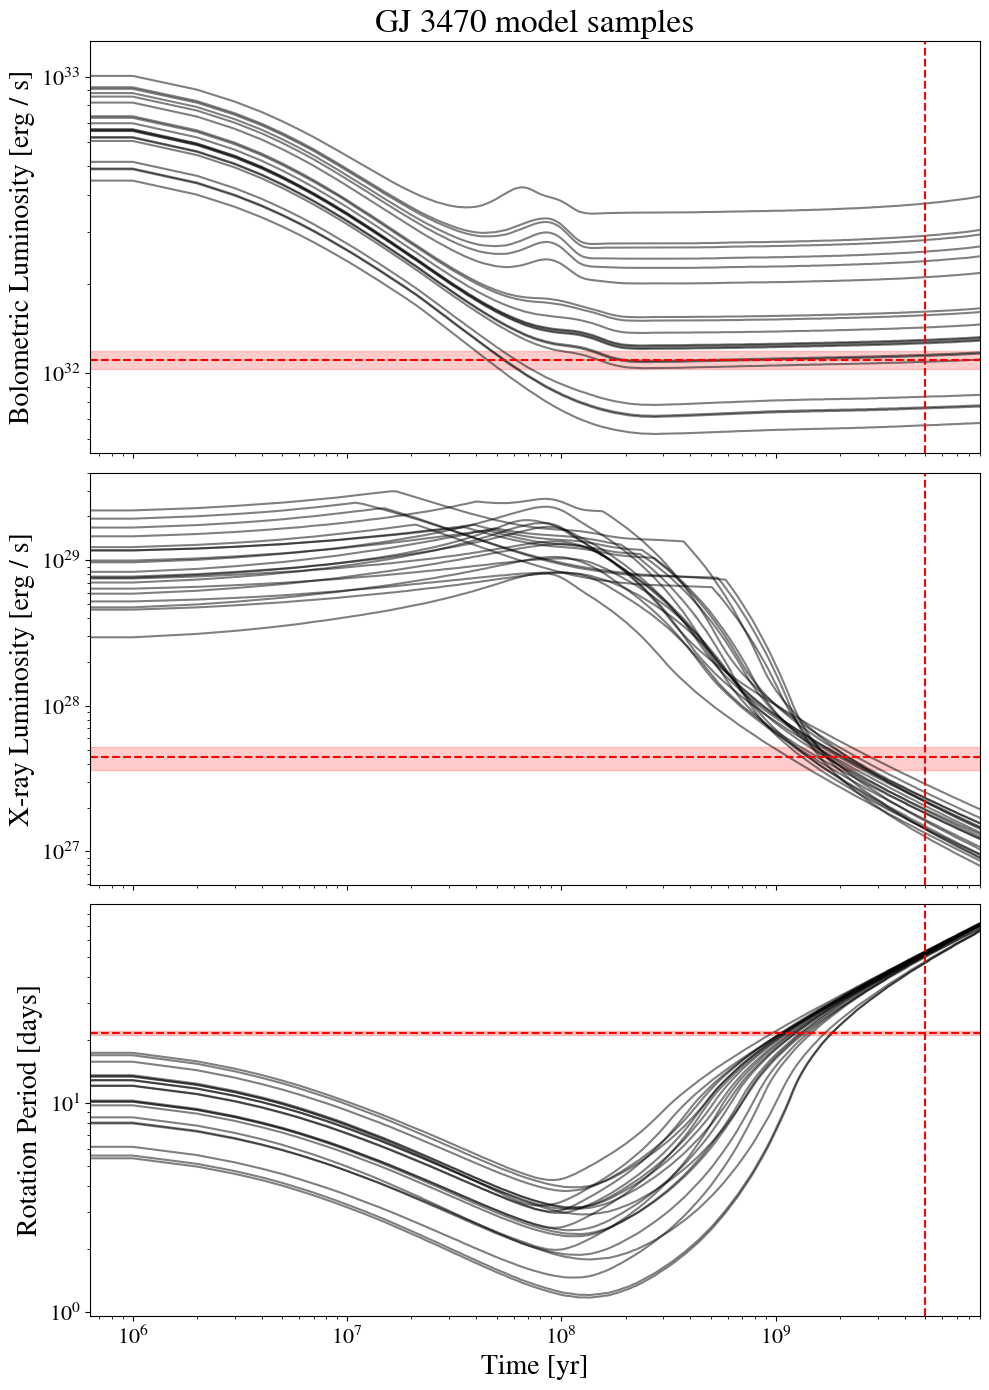

In [131]:
fig = plot_evolution(evols, title="GJ 3470 model samples")
axs = fig.axes

axs[0].axhline(Lbol_data[0], color="r", linestyle="--")
axs[0].axhspan(Lbol_data[0]+Lbol_data[1], Lbol_data[0]+Lbol_data[2], color="r", alpha=0.2)

axs[1].axhline(Lxuv_data[0], color="r", linestyle="--")
axs[1].axhspan(Lxuv_data[0]+Lxuv_data[1], Lxuv_data[0]+Lxuv_data[2], color="r", alpha=0.2)

axs[2].axhline(Prot_data[0], color="r", linestyle="--")
axs[2].axhspan(Prot_data[0]+Prot_data[1], Prot_data[0]+Prot_data[2], color="r", alpha=0.2)

for ii in range(len(axs)):
    axs[ii].axvline(age_data[0], color="r", linestyle="--")
    axs[ii].axvspan(age_data[0]+age_data[1], age_data[0]+age_data[2], color="r", alpha=0.2)

fig.show()

In [132]:
model1_finalXUV =(evols[0]["final.star.LXUV"][-1]).to(u.erg/u.s).value
(model1_finalXUV - Lxuv_data[0])**2/Lxuv_data[1]**2
#closer to 0 is less deviation, getting mean from the data and comparing to original mean, chi squared 

21.276947731233452

### Sample 3 55 Cnc

Parameters and uncertainties of 55 Cnc model

    From Host star parameters from Exostars catalog and NASA exoplanet archive


In [114]:
#Parameters and uncertainties
#Thetas to Omega2
#[best fit, standard deviation, nsamp]
nsamp = 20
mass_samp = np.random.normal(0.85	, 0.02, nsamp)
prot_samp = np.random.uniform(0.01, 5.535, nsamp)
age_samp = np.ones(nsamp) * 5.0
beta1_samp = np.random.normal(j21["beta1"][0], j21["beta1"][1], nsamp)
beta2_samp = np.random.normal(j21["beta2"][0], j21["beta2"][1], nsamp)
Rosat_samp = np.random.normal(j21["Rosat"][0], j21["Rosat"][1], nsamp)
RXsat_samp = np.random.normal(j21["RXsat"][0], j21["RXsat"][1], nsamp)

Omega2 = np.array([mass_samp, prot_samp, age_samp, beta1_samp, beta2_samp, Rosat_samp, RXsat_samp]).T

# Run with multiple cores
ncores = mp.cpu_count()
print("number of cores available:", ncores)
with mp.Pool(ncores) as pool:
    evols = pool.starmap(LXUV_model, Omega2)

# If multiple cores does not work, comment out the previous two lines and uncomment the following lines 
# evols = []
# for ii in range(nsamp):
#     evols.append(LXUV_model(*thetas[ii]))

number of cores available: 8

Input:
Input:
Input:
Input:
Input:
Input:
Input:




-----------------

-------------------------------------------------------------------------------------


star.dMass : 0.8814150867813404 [solMass] (user)   --->   1.7526144587381965e+30 [kg] (vpl file)star.dMass : 0.842552677416192 [solMass] (user)   --->   1.675340060357427e+30 [kg] (vpl file)star.dMass : 0.8311056717358747 [solMass] (user)   --->   1.6525787212727474e+30 [kg] (vpl file)



star.dRotPeriod : 5.4313551765691255 [days] (user)   --->   469269.08725557243 [s] (vpl file)
star.dMass : 0.8683291381572832 [solMass] (user)   --->   1.7265942293266735e+30 [kg] (vpl file)star.dRotPeriod : 5.472346313096598 [days] (user)   --->   472810.7214515461 [s] (vpl file)star.dMass : 0.8224869218961818 [solMass] (user)   --->   1.6354411140184247e+30 [kg] (vpl file)-----------------
star.dRotPeriod : 1.2195033368269093 [days] (user)   --->   105365.08830184495 [s] (vpl file)


star.dMass : 0.83966611298712

In [115]:
# data = [mean, lower error, upper error]

Lbol_data = np.array([0.582	,-0.014,	0.014]) * u.Lsun
Lbol_data = Lbol_data.to(u.erg/u.s).value

Lxuv_data = np.array([5.23e25,	-6.43e25,	6.43e25]) * u.Lsun
Lxuv_data = Lxuv_data.value

Prot_data = np.array([38.8, -0.05, 0.05]) * u.day
Prot_data = Prot_data.value

age_data = np.array([10.2, -2.5, 2.5]) * u.Gyr
age_data = age_data.to(u.yr).value

/tmp/ipykernel_17746/687210072.py:33: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[0].set_xlim(min(evol["Time"].value), max(evol["Time"].value))
/tmp/ipykernel_17746/64737029.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


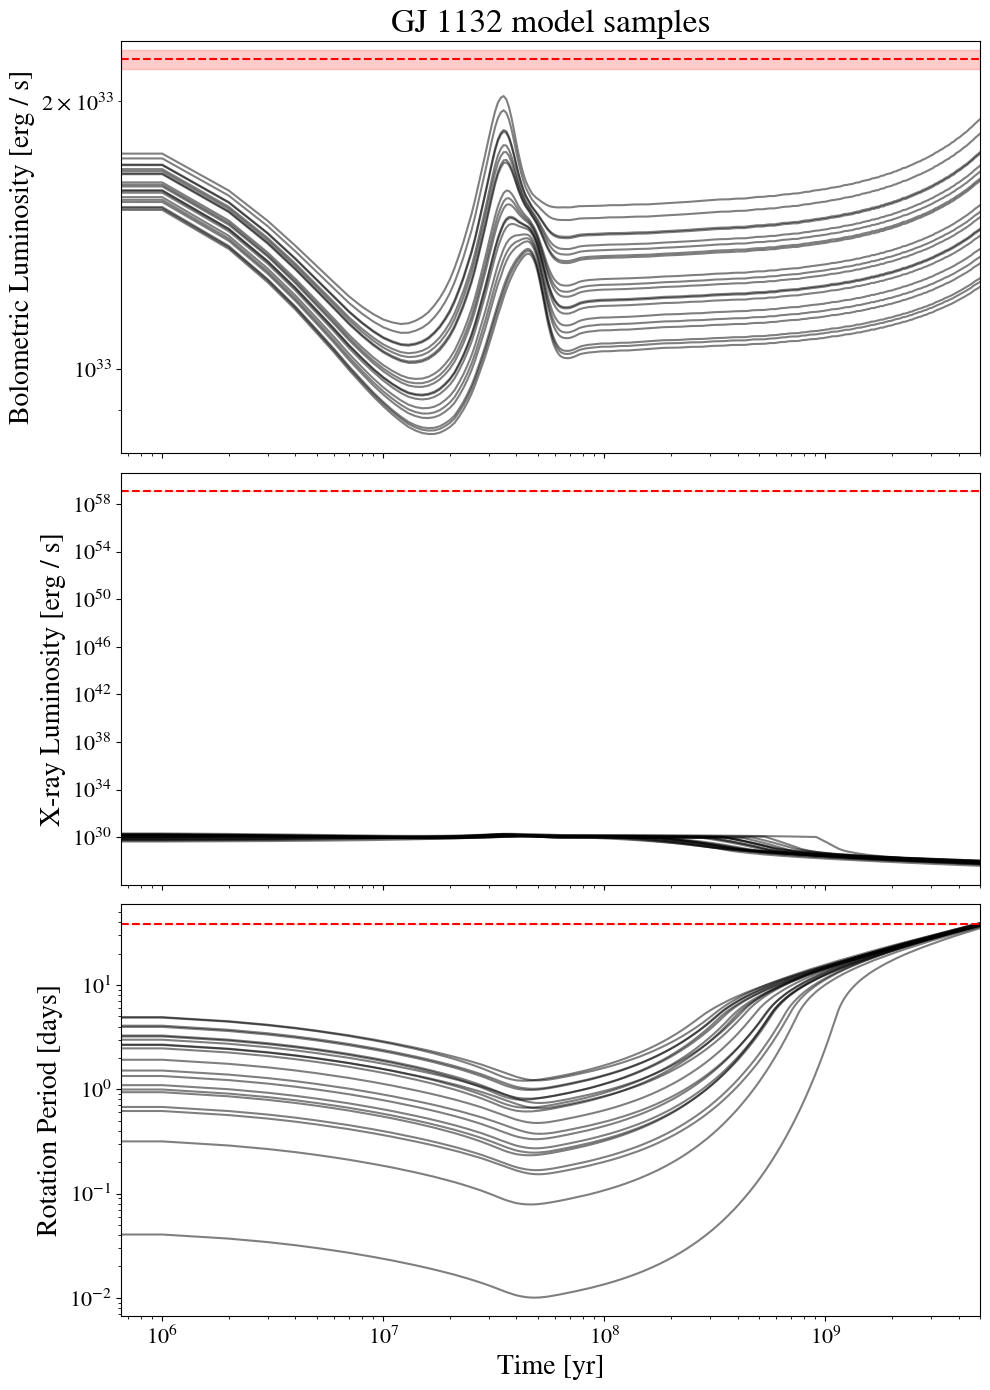

In [116]:
fig = plot_evolution(evols, title="GJ 1132 model samples")
axs = fig.axes

axs[0].axhline(Lbol_data[0], color="r", linestyle="--")
axs[0].axhspan(Lbol_data[0]+Lbol_data[1], Lbol_data[0]+Lbol_data[2], color="r", alpha=0.2)

axs[1].axhline(Lxuv_data[0], color="r", linestyle="--")
axs[1].axhspan(Lxuv_data[0]+Lxuv_data[1], Lxuv_data[0]+Lxuv_data[2], color="r", alpha=0.2)

axs[2].axhline(Prot_data[0], color="r", linestyle="--")
axs[2].axhspan(Prot_data[0]+Prot_data[1], Prot_data[0]+Prot_data[2], color="r", alpha=0.2)

for ii in range(len(axs)):
    axs[ii].axvline(age_data[0], color="r", linestyle="--")
    axs[ii].axvspan(age_data[0]+age_data[1], age_data[0]+age_data[2], color="r", alpha=0.2)

fig.show()

In [117]:
model1_finalXUV =(evols[0]["final.star.LXUV"][-1]).to(u.erg/u.s).value
(model1_finalXUV - Lxuv_data[0])**2/Lxuv_data[1]**2
#closer to 0 is less deviation, getting mean from the data and comparing to original mean, chi squared 

1143.329290965531